Hello there, it has been a while since our last notebook. Welcome again to my learning process of Artificial Intelligence course by Professor Nguyen Truong Thinh.
In this notebook, I am working on the topic of Insurance Premium Prediction for predicting future medical expenses of individuals that help medical insurance to make decision on charging the premium.\
**Dataset source:** https://www.kaggle.com/datasets/noordeen/insurance-premium-prediction

In [1]:
# Import libraries in used
import pandas as pd               # Use in processing Dataframe
import numpy as np                # Use in processing mathematic matrices
import matplotlib.pyplot as plt   # Use in plotting
import seaborn as sns             # Use in data insights mining
from sklearn import linear_model  # Use in creating Linear prediction model

# Import 'tools' for data processing
from sklearn.preprocessing import StandardScaler      # Use in scaling dataset
from sklearn.model_selection import train_test_split  # Use in splitting the dataset

In [18]:
# Turn off unecessary warnings from scikit-learn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Store file path/url and read data from it
file_path = '/content/insurance.csv'   # Using downloaded file path

# Read data with Pandas
insurance_rawdata = pd.read_csv(file_path)

# Review some first instances of the set
insurance_rawdata.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
# Data uniqueness (text data)
insurance_rawdata['sex'].unique()

array(['female', 'male'], dtype=object)

In [9]:
# Data uniqueness (text data)
insurance_rawdata['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [11]:
# Data uniqueness (text data)
insurance_rawdata['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [3]:
# The summarized info. of the data
insurance_rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


**COMMENT 1:**
This dataset contains 7 columns of data catgories and 1338 entries of instances. As we can see each category has fully 1338 instances, there aren't any missing ones among them.\
Through the first glance of the dataset, I pointed out some of the problems in making a predictor, I will show them in set like: age-bmi, age-children, age-smoker, sex-bmi, sex-smoker. Those are pairs that in my opinion should not be predicted in whatever relations. Why?\
There are many possible cases of BMI in all ages, or many different number of children within a family with different ages of parents. Those problems may result in a silly predictors. Hmm, however only the correlation plot that makes sense

In [22]:
# Get rid off the none numeric categories
# 'Region' only, for the case of 'sex' and 'smoker', it will be encoded
insurance_notext = insurance_rawdata.drop(['region'], axis=1)
print("Dataset after processed")
insurance_notext.head()

Dataset after processed


,age,sex,bmi,children,smoker,charges
0,19,female,27.900,0,yes,16884.92400
1,18,male,33.770,1,no,1725.55230
2,28,male,33.000,3,no,4449.46200
3,33,male,22.705,0,no,21984.47061
4,32,male,28.880,0,no,3866.85520


In [23]:
## Data encoding ##
# For 'sex'   : Female = 0, Male = 1
# For 'smoker': Yes = 1; No = 0
insurance_notext['sex'][insurance_notext['sex'] == 'female'] = 0    # Encode sex: female = 0
insurance_notext['sex'][insurance_notext['sex'] == 'male']   = 1    # Encode sex: male   = 1

insurance_notext['smoker'][insurance_notext['smoker'] == 'no']  = 0    # Encode sex: no  = 0
insurance_notext['smoker'][insurance_notext['smoker'] == 'yes'] = 1    # Encode sex: yes = 1

''' The original type of sex each instance is 'object', and it still remains even encoded with number
    , thus it needed to be converted to numeric '''

# Convert text and object to numeric
insurance_notext['sex']    = pd.to_numeric(insurance_notext['sex'], downcast='integer')
insurance_notext['smoker'] = pd.to_numeric(insurance_notext['smoker'], downcast='integer')

In [24]:
insurance_notext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int8   
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int8   
 5   charges   1338 non-null   float64
dtypes: float64(2), int64(2), int8(2)
memory usage: 44.6 KB


<Axes: >

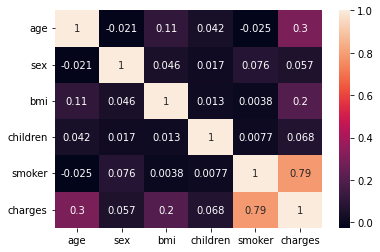

In [25]:
## Correlations ##
insurance_corr = insurance_notext.corr()
sns.heatmap(insurance_corr, annot=True)   # Correlation with seaborn

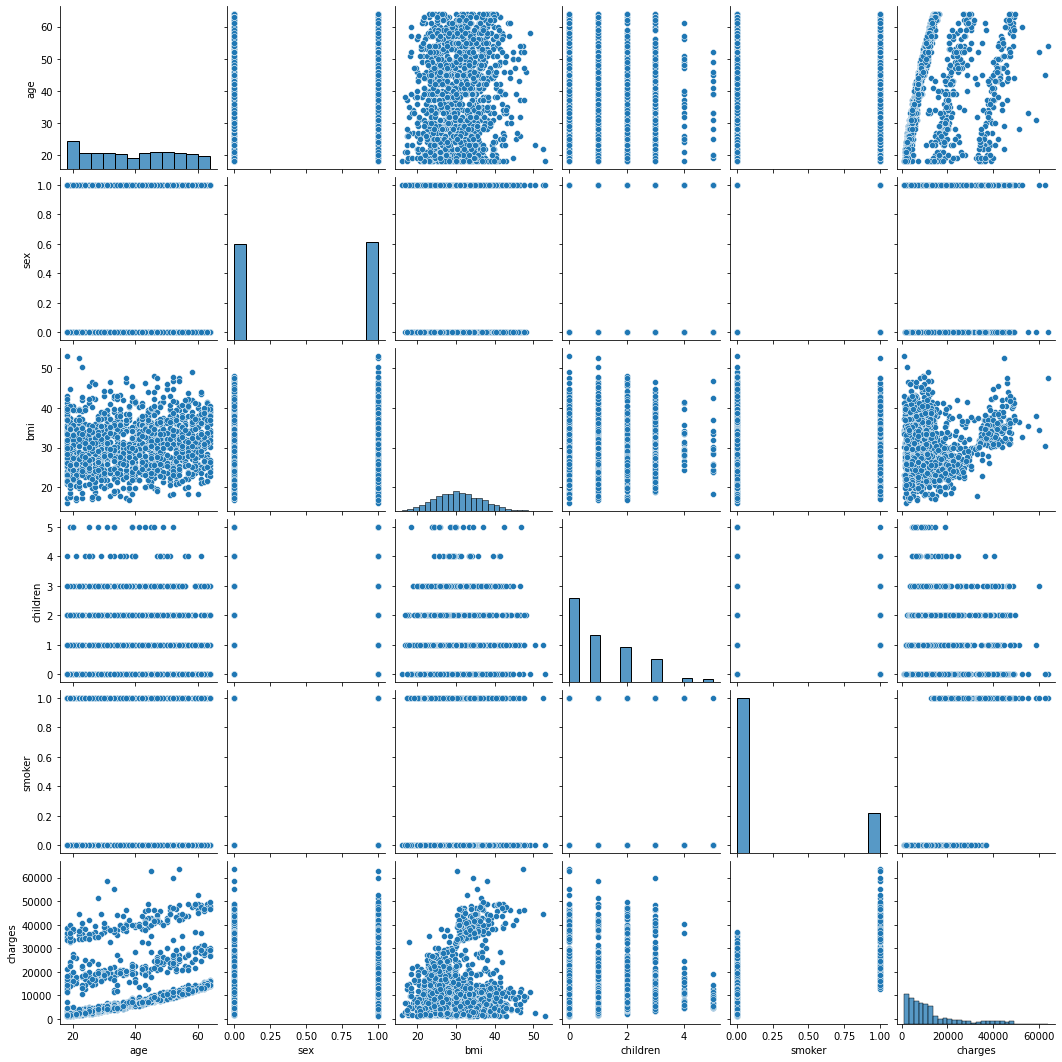

In [26]:
## Pairs Plotting ##
sns.pairplot(insurance_notext)   # Pairs plotting with seaborn

**COMMENT 2:**\
As I've mentioned, but this time they are even worst. We hardly see any linear relations between them since both the correlations heatmap and the plots have shown. I considered this dataset is suitable for a classification task or non-linear predictions

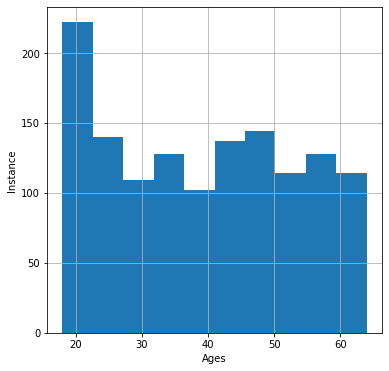

In [34]:
## Histogram ##
plt.figure(figsize=[6, 6])
insurance_notext['age'].hist()   # Have a look at data distribution - Age
plt.xlabel('Ages')
plt.ylabel('Instance')
plt.show()

Quite a uniform distribution

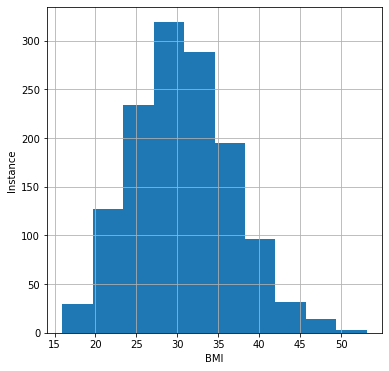

In [36]:
plt.figure(figsize=[6, 6])
insurance_notext['bmi'].hist()   # Have a look at data distribution - BMI
plt.xlabel('BMI')
plt.ylabel('Instance')
plt.show()

A close bell-shaped distributions

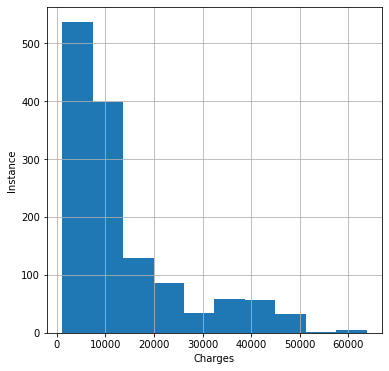

In [37]:
plt.figure(figsize=[6, 6])
insurance_notext['charges'].hist()   # Have a look at data distribution - Charges
plt.xlabel('Charges')
plt.ylabel('Instance')
plt.show()

Let's make some more plots before getting deeper in the prediction tasks

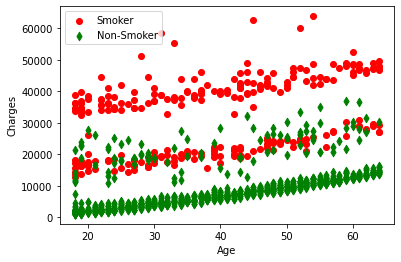

In [41]:
## Clusters Plotting ##
# Age-Charges-Smoker
age_smoker     = insurance_notext['age'][insurance_notext['smoker']==1]      # Smoker
charges_smoker = insurance_notext['charges'][insurance_notext['smoker']==1]

age_nonsmoker     = insurance_notext['age'][insurance_notext['smoker']==0]   # Non Smoker
charges_nonsmoker = insurance_notext['charges'][insurance_notext['smoker']==0]

# Scattering: Age respecting to charges
plt.scatter(age_smoker, charges_smoker, marker='o', color='red')
plt.scatter(age_nonsmoker, charges_nonsmoker, marker='d', color='green')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(['Smoker', 'Non-Smoker'])
plt.show()

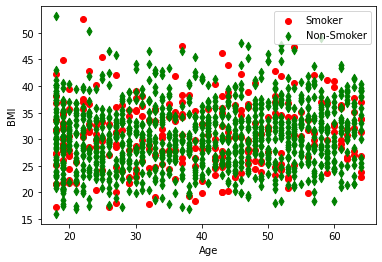

In [42]:
## Clusters Plotting ##
# Age-BMI-Smoker
age_smoker = insurance_notext['age'][insurance_notext['smoker']==1]      # Smoker
bmi_smoker = insurance_notext['bmi'][insurance_notext['smoker']==1]

age_nonsmoker = insurance_notext['age'][insurance_notext['smoker']==0]   # Non Smoker
bmi_nonsmoker = insurance_notext['bmi'][insurance_notext['smoker']==0]

# Scattering: Age respecting to BMI
plt.scatter(age_smoker, bmi_smoker, marker='o', color='red')
plt.scatter(age_nonsmoker, bmi_nonsmoker, marker='d', color='green')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.legend(['Smoker', 'Non-Smoker'])
plt.show()

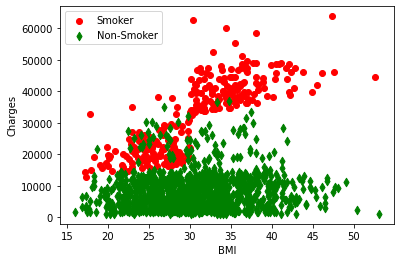

In [43]:
## Clusters Plotting ##
# BMI_Charges-Smoker
plt.scatter(bmi_smoker, charges_smoker, marker='o', color='red')
plt.scatter(bmi_nonsmoker, charges_nonsmoker, marker='d', color='green')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend(['Smoker', 'Non-Smoker'])
plt.show()

**TRIAL TEST: A CLASSIFICATION TASK: SMOKER OR NOT BASED ON BMI AND CHARGES**

In [45]:
# Import model from libraries
from sklearn.linear_model import LogisticRegression

In [47]:
# Create the set to train and evaluate
bmi_charges  = pd.DataFrame(insurance_notext[['bmi', 'charges']])
smoker_class = pd.DataFrame(insurance_notext['smoker'])

# Create the model
smoker_classifier = LogisticRegression()

In [52]:
bmi_charges.head()

,bmi,charges
0,27.900,16884.92400
1,33.770,1725.55230
2,33.000,4449.46200
3,22.705,21984.47061
4,28.880,3866.85520


In [50]:
# Train - Test Splitting
bmi_charges_train, bmi_charges_test, class_train, class_test = train_test_split(bmi_charges, smoker_class, test_size=0.20, random_state=42)

In [51]:
# Train the model
smoker_classifier.fit(bmi_charges_train, class_train)

# Evaluation score
train_score = smoker_classifier.score(bmi_charges_train, class_train)
test_score  = smoker_classifier.score(bmi_charges_test, class_test)
print("Train Score of Model:", train_score)
print("Test Score of Model:", test_score)

Train Score of Model: 0.9252336448598131
Test Score of Model: 0.9440298507462687


Hmmm, it's kinda weird in this accuracy, since the train score is often larger than the test one.

Let's make boundary with this model and observe what is happening

In [53]:
####### DECISION BOUNDARY CREATING FUNCTION #######
def decisionBoundary(min1, max1, min2, max2, lensize, trained_model, plt_len, plt_wid):
  len_size = lensize
  x1_range_other  = np.linspace(min1, max1, len_size).reshape(len_size, 1)
  x2_range_other  = np.linspace(min2, max2, len_size).reshape(len_size, 1)
  pred_val_other  = np.zeros((len_size, len_size))

  # Combine every x-y and make prediction to finally classify them
  for i in range(len_size):
    for j in range(len_size):
      pred_val_other[i, j] = trained_model.predict([[x1_range_other[i, 0], x2_range_other[j, 0]]]).max()

  # Create meshgrid and plot decision boundary for clusters
  plt.figure(figsize = [plt_len, plt_wid])
  mesh_l, mesh_w = np.meshgrid(x1_range_other, x2_range_other)
  contour_set = plt.contour(mesh_l, mesh_w, pred_val_other.T, colors = 'green')

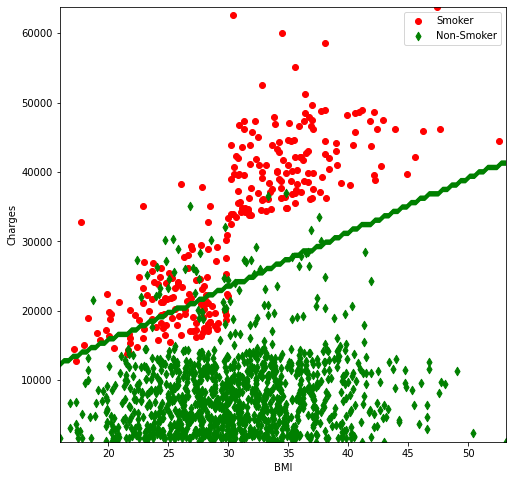

In [54]:
# Find limits
min_bmi = np.amin(bmi_charges['bmi'])
max_bmi = np.amax(bmi_charges['bmi'])
min_charges = np.amin(bmi_charges['charges'])
max_charges = np.amax(bmi_charges['charges'])

# Make Plot
decisionBoundary(min_bmi, max_bmi, min_charges, max_charges, 100, smoker_classifier, 8, 8)

# Plot original data
# BMI_Charges-Smoker
plt.scatter(bmi_smoker, charges_smoker, marker='o', color='red')
plt.scatter(bmi_nonsmoker, charges_nonsmoker, marker='d', color='green')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend(['Smoker', 'Non-Smoker'])
plt.show()

This decision boundary is not too perfect, but can classify most cases. To make a highly fitted boundary, the model most closely overfitting the data. So, let's try to train a stronger one

In [103]:
# Create the model
smoker_classifier_longer = LogisticRegression(solver='newton-cholesky', max_iter=5000)

# Train the model
smoker_classifier_longer.fit(bmi_charges_train, class_train)

LogisticRegression(max_iter=5000, solver='newton-cholesky')

In [104]:
# Evaluation score
train_score = smoker_classifier_longer.score(bmi_charges_train, class_train)
test_score  = smoker_classifier_longer.score(bmi_charges_test, class_test)
print("Train Score of Model:", train_score)
print("Test Score of Model:", test_score)

Train Score of Model: 0.9317757009345794
Test Score of Model: 0.9440298507462687


Not much!

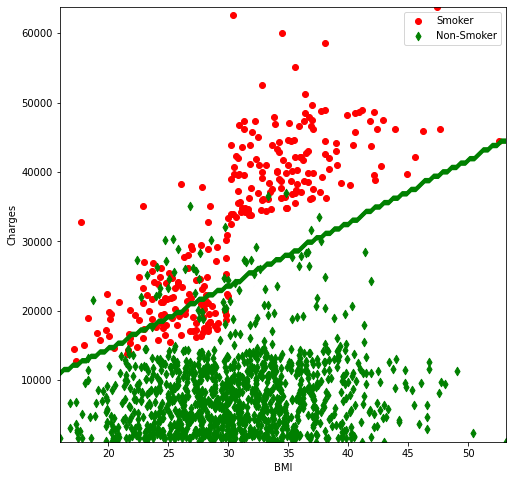

In [105]:
### THIS TIME, MAKING A DECISION BOUNDARY WITH PERCEPTRON MODEL ###
# Make Plot
decisionBoundary(min_bmi, max_bmi, min_charges, max_charges, 100, smoker_classifier_longer, 8, 8)

# Plot original data
# BMI_Charges-Smoker
plt.scatter(bmi_smoker, charges_smoker, marker='o', color='red')
plt.scatter(bmi_nonsmoker, charges_nonsmoker, marker='d', color='green')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend(['Smoker', 'Non-Smoker'])
plt.show()

In [109]:
from sklearn import svm

In [123]:
# Create the model - SVM
smoker_classifier_svm = svm.SVC(kernel='linear', degree=10, max_iter=-1)

# Train the model
smoker_classifier_svm.fit(bmi_charges_train, class_train)

# Evaluation score
train_score = smoker_classifier_svm.score(bmi_charges_train, class_train)
test_score  = smoker_classifier_svm.score(bmi_charges_test, class_test)
print("Train Score of Model:", train_score)
print("Test Score of Model:", test_score)

Train Score of Model: 0.9383177570093458
Test Score of Model: 0.9365671641791045


Not even better!

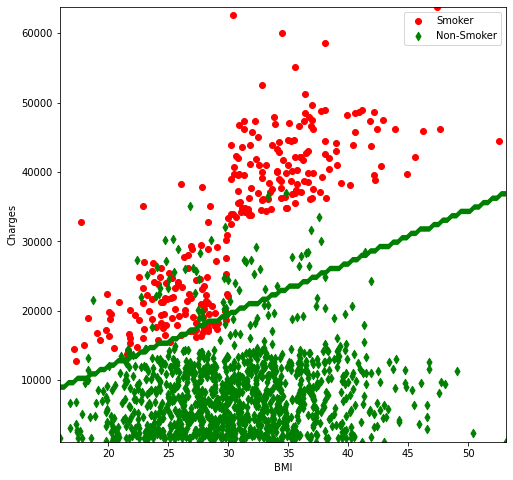

In [124]:
# Make Plot
decisionBoundary(min_bmi, max_bmi, min_charges, max_charges, 100, smoker_classifier_svm, 8, 8)

# Plot original data
# BMI_Charges-Smoker
plt.scatter(bmi_smoker, charges_smoker, marker='o', color='red')
plt.scatter(bmi_nonsmoker, charges_nonsmoker, marker='d', color='green')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend(['Smoker', 'Non-Smoker'])
plt.show()

It looks like we have reached the point of saturation

**TRIAL: AGE - CHARGE - SMOKER**

In [167]:
# Let's consider one last set of: Age-Charges-Smoker
# Create the set to train and evaluate
age_charges  = pd.DataFrame(insurance_notext[['age', 'charges']])

In [168]:
# Train - Test Splitting
age_charges_train, age_charges_test, class_train, class_test = train_test_split(age_charges, smoker_class, test_size=0.20, random_state=42)

In [171]:
# Create the model
smoker_classifier = LogisticRegression(solver='newton-cholesky', max_iter=100)

In [172]:
# Train the model
smoker_classifier.fit(age_charges_train, class_train)

# Evaluation score
train_score = smoker_classifier.score(age_charges_train, class_train)
test_score  = smoker_classifier.score(age_charges_test, class_test)
print("Train Score of Model:", train_score)
print("Test Score of Model:", test_score)

Train Score of Model: 0.9009345794392524
Test Score of Model: 0.9029850746268657


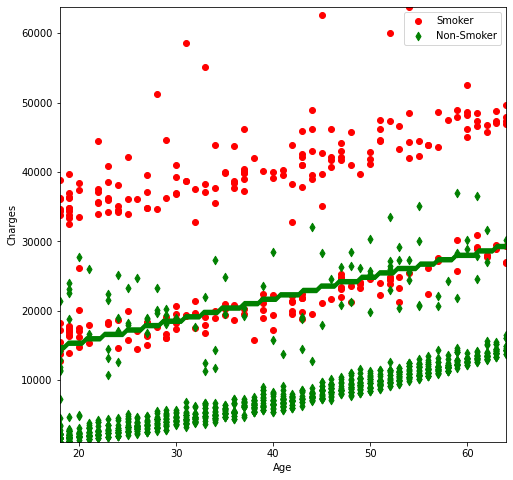

In [173]:
# Find limits
min_age     = np.amin(age_charges['age'])
max_age     = np.amax(age_charges['age'])
min_charges = np.amin(bmi_charges['charges'])
max_charges = np.amax(bmi_charges['charges'])

# Make Plot
decisionBoundary(min_age, max_age, min_charges, max_charges, 100, smoker_classifier, 8, 8)

# Plot original data
# BMI_Charges-Smoker
plt.scatter(age_smoker, charges_smoker, marker='o', color='red')
plt.scatter(age_nonsmoker, charges_nonsmoker, marker='d', color='green')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(['Smoker', 'Non-Smoker'])
plt.show()